# Assignment 1 - __M&M Factory QA__

- To calculate:

    - [ ] Color distribuition. Must warn if any color is missing
    
    - [ ] Average shape area in mm and organized by color
    
[Documentation online](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html)
     
 A) Calibrate intrinsic paramenters and lens distortion of the camera. Show the intrinsic matrix and the lens distortion coeffiecients.
  

In [2]:
%pip install opencv-python
%pip install matplotlib
%pip install sympy

from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import glob
import sympy


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# __Detection of Checkboard__

Loading Image data/IntrinsicCalibration/calib_img_0.png


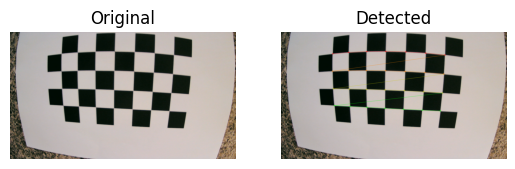

Loading Image data/IntrinsicCalibration/calib_img_1.png


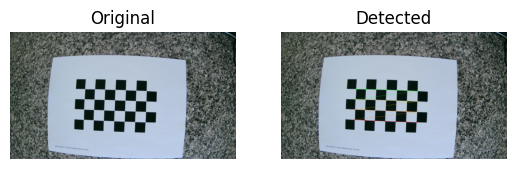

Loading Image data/IntrinsicCalibration/calib_img_2.png


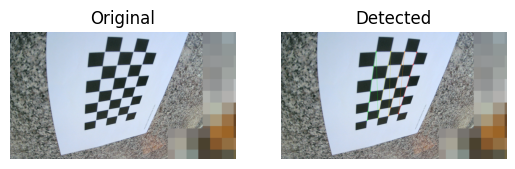

Loading Image data/IntrinsicCalibration/calib_img_3.png


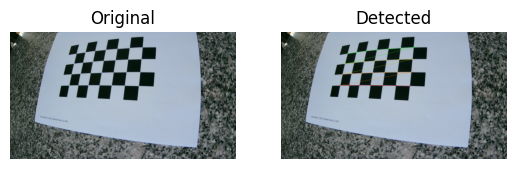

Loading Image data/IntrinsicCalibration/calib_img_4.png


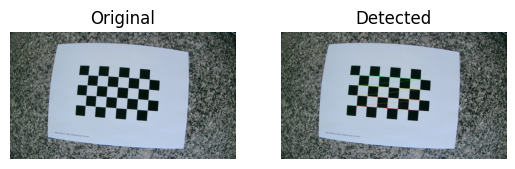

Loading Image data/IntrinsicCalibration/calib_img_5.png


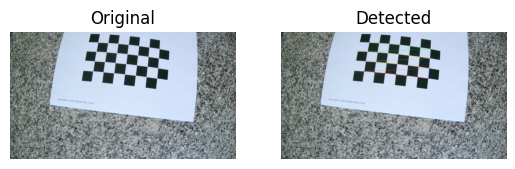

Loading Image data/IntrinsicCalibration/calib_img_6.png


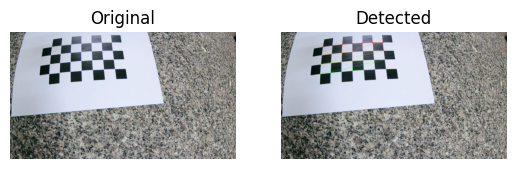

Loading Image data/IntrinsicCalibration/calib_img_7.png


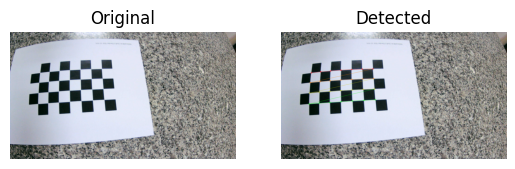

Loading Image data/IntrinsicCalibration/calib_img_8.png


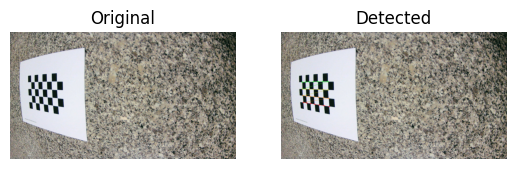

Loading Image data/IntrinsicCalibration/calib_img_9.png


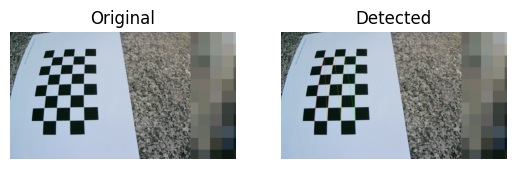

In [3]:
# tuple that says the grid size (note these are interior corners)
grid_size = (7,4) 

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((grid_size[1]*grid_size[0],3), np.float32)
objp[:,:2] = np.mgrid[0:grid_size[0],0:grid_size[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = sorted(glob.glob('data/IntrinsicCalibration/calib_img_[0-9].png'))

for fname in images:

    print(f"Loading Image {fname}")
    img = cv.imread(fname)
    
    plt.subplot(1,2,1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv.findChessboardCornersSB(gray, grid_size, None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, grid_size, corners2, ret)
        
    plt.subplot(1,2,2)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Detected')
    plt.show()


## Calculating Intrinsic Camera Matrix 

In [4]:
from sympy import *

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print(f" Intrinsic Matrix :")
pprint(sympy.Matrix(mtx).applyfunc(lambda x: Symbol('{:.3f}'.format(x))))

#print(f"\n Rotation Matrix : ")
#pprint(sympy.Matrix(rvecs))
#print(f"\n Translation Matrix : ")
#pprint(sympy.Matrix(tvecs))
# TO DO RODRIGUES ROTATION MATRIX TO VECTOR? 


 Intrinsic Matrix :
⎡1318.933   0.000    995.231⎤
⎢                           ⎥
⎢ 0.000    1321.213  641.452⎥
⎢                           ⎥
⎣ 0.000     0.000     1.000 ⎦


Loading Image data/IntrinsicCalibration/calib_img_0.png


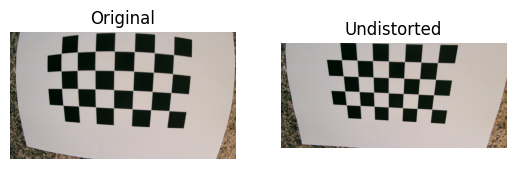

Loading Image data/IntrinsicCalibration/calib_img_1.png


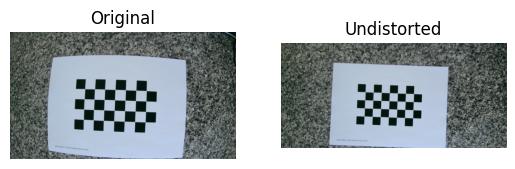

Loading Image data/IntrinsicCalibration/calib_img_2.png


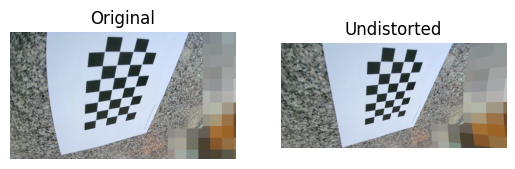

Loading Image data/IntrinsicCalibration/calib_img_3.png


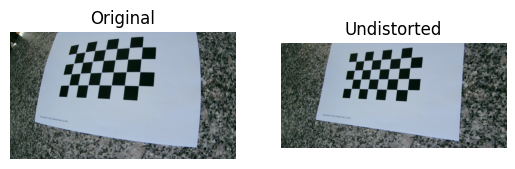

Loading Image data/IntrinsicCalibration/calib_img_4.png


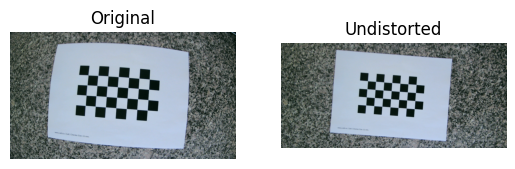

Loading Image data/IntrinsicCalibration/calib_img_5.png


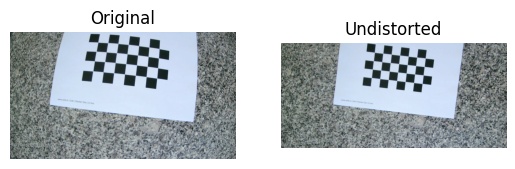

Loading Image data/IntrinsicCalibration/calib_img_6.png


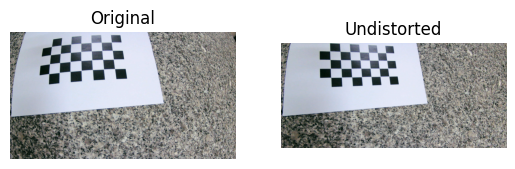

Loading Image data/IntrinsicCalibration/calib_img_7.png


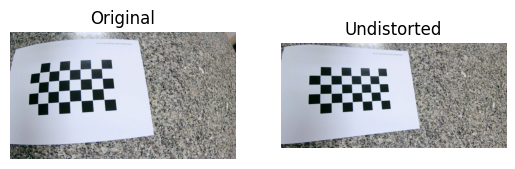

Loading Image data/IntrinsicCalibration/calib_img_8.png


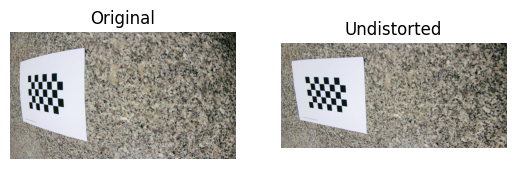

Loading Image data/IntrinsicCalibration/calib_img_9.png


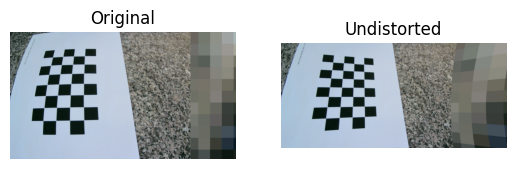

In [5]:
images = sorted(glob.glob('data/IntrinsicCalibration/calib_img_[0-9].png'))
unwarped_img = []
for fname in images:

    print(f"Loading Image {fname}")
    img = cv.imread(fname)
    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # undistort
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    plt.subplot(1,2,1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
    plt.title("Undistorted")
    plt.show()
    unwarped_img.append(dst)


# Segmentation

_Note on HSV_

HSV is Hue, Saturation and Value. Hue is normally described in an angle from 0º to 360º, to keep the color type with the same size as the other opencv's implemetation of hue is in the range of 0-180 as it still under the 255 limit imposed by the int8 data type.
To help relate what we saw in photoediting software, that we used to determined the range of suitable vales, we created this funtion which delivers a range between 0 a 255

In [6]:
def old_way():
    #define range of red color in HSV from 0-180 range
    lower_red = np.array([np.max([0,(central_red-band_red)]), low_saturation, 0])
    upper_red = np.array([np.min([180,(central_red+band_red)]),255,255])

    lower_blue = np.array([np.max([0,(central_blue-band_blue)]), low_saturation, 0])
    upper_blue = np.array([np.min([180,(central_blue+band_blue)]),255,255])
    
    lower_yellow = np.array([np.max([0,(central_yellow-band_yellow)]) ,low_saturation  ,0  ])
    upper_yellow = np.array([np.min([180,(central_yellow+band_yellow)]) ,255,255])
    
    lower_green = np.array([np.max([0,(central_green-band_green)]) ,low_saturation  ,0  ])
    upper_green = np.array([np.min([180,(central_green+band_green)]) ,255,255])

    #Threshold the HSV image using inRange function to get only red colors
    mask_red = cv.inRange(hsv, lower_red, upper_red )
    mask_blue = cv.inRange(hsv, lower_blue, upper_blue )
    mask_yellow = cv.inRange(hsv, lower_yellow, upper_yellow )
    mask_green = cv.inRange(hsv, lower_green, upper_green )


In [7]:
def plot_results():
    # Display image using plt
    plt.figure(figsize=(40,40))

    plt.subplot(441)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(442)
    plt.imshow(h, cmap ="gray")
    plt.title("Hue")
    plt.axis("off")
    
    plt.subplot(443)
    plt.imshow(s, cmap="gray")
    plt.title("Saturation")
    plt.axis("off")

    plt.subplot(444)
    plt.imshow(mask_sat, cmap= "gray")
    plt.title("Sat Mask")
    plt.axis("off")

    plt.subplot(445)
    plt.imshow(mask_red, cmap="gray")
    plt.title("Red M&Ms")
    plt.axis("off")

    plt.subplot(446)
    plt.imshow(mask_blue, cmap="gray")
    plt.title("Blue M&Ms")
    plt.axis("off")
    
    plt.subplot(447)
    plt.imshow(mask_yellow, cmap="gray")
    plt.title("Yellow M&Ms")
    plt.axis("off")

    plt.subplot(448)
    plt.imshow(mask_green, cmap="gray")
    plt.title("Green M&Ms")
    plt.axis("off")

    plt.subplot(449)
    plt.imshow(mask_sat_red , cmap="gray")
    plt.title("Sat AND Red")
    plt.axis("off")

    plt.subplot(4,4,10)
    plt.imshow(mask_sat_blue , cmap ="gray")
    plt.title("Sat AND Blue")
    plt.axis("off")
    
    plt.subplot(4,4,11)
    plt.imshow(mask_sat_yellow , cmap="gray")
    plt.title("Sat AND Yellow")
    plt.axis("off")

    plt.subplot(4,4,12)
    plt.imshow(mask_sat_green, cmap= "gray")
    plt.title("Sat AND Green")
    plt.axis("off")

    plt.subplot(4,4,13)
    plt.imshow(final_red)
    plt.title("FINAL Green")
    plt.axis("off")
    plt.subplot(4,4,14)
    plt.imshow(final_blue)
    plt.title("FINAL Green")
    plt.axis("off")
    plt.subplot(4,4,15)
    plt.imshow(final_yellow)
    plt.title("FINAL Green")
    plt.axis("off")
    plt.subplot(4,4,16)
    plt.imshow(final_green)
    plt.title("FINAL Green")
    plt.axis("off")



    plt.show()

In [8]:
def plot_mask(mask, title):
    plt.imshow(mask, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

In [9]:
def calculate_boundary(center, margin, inputType='abs'): 
    inv = 0
    if inputType == 'abs':
        #from 0 to 255
        if center+margin > 255 :
            inv = 1
            lb = int(np.max([0, (center+margin)-255])) 
            hb = int(np.min([(center-margin),255]))
        elif  center-margin < 0:
            inv = 1
            lb = int(np.max([(center+margin), 0])) 
            hb = int(np.min([(255-np.abs(center-margin)),255]))
        else:
            lb = int(np.max([(center-margin),0]))
            hb = int(np.min([(center+margin),255])) 
    if inputType == 'deg':
        #from center 0 to 180
        center_deg = center*(255/180)
        margin_deg = margin*(255/180)
        lb = int(np.max([(center_deg-margin_deg)*ratio,0]))
        hb = int(np.min([(center_deg+margin_deg)*ratio,255])) # percentage of the range covered

    return (inv, [lb, hb])

In [10]:
def segment_sat(img, thres):
    low_saturation = int(np.min([255,thres*2.55]))# in 0, 255 range 
    _, mask_sat =    cv.threshold(img, low_saturation, 255           , cv.THRESH_BINARY)
    
    #Clean up saturation mask
    kernel = np.ones((7, 7), np.uint8)
  
    # The first parameter is the original image,
    # kernel is the matrix with which image is
    # convolved and third parameter is the number
    # of iterations, which will determine how much
    # you want to erode/dilate a given image.

    sat_cleaned = cv.erode(mask_sat, kernel, iterations=5)
    sat_cleaned = cv.dilate(sat_cleaned, kernel, iterations=7)

    return sat_cleaned


In [12]:
def background():
    mask_bg = segment_color(h, 155, 35)
    plot_mask(mask_bg, "background")
    positions = np.nonzero(mask_bg)
    top = positions[0].min()
    bottom = positions[0].max()
    left = positions[1].min()
    right = positions[1].max()

    nobg = img[top:bottom, left:right]
    plt.imshow(cv.cvtColor(nobg,cv.COLOR_BGR2RGB))
    plt.title("img cut")
    plt.axis("off")
    plt.show()

    output = cv.rectangle(img, (left, top), (right, bottom), (0,255,0), 1)
    plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    plt.title("img with box")
    plt.axis("off")
    plt.show()

In [13]:
def segment_color(hue, target, margin):    
    #the Hue is the component that can help us separate the candies.
    # We can assume that the M&M will be the most saturated thing 
    # in the picture. To address this we implement a high pass filter 
    # on the saturation channel

    max_hue = 180   #   account for full hsv or not cause idk what im doing by now
    if(np.max(hue) > 180):
        max_hue = 255

    inv, band = calculate_boundary(target, margin)

    if inv == 1:
        _, mask_l =    cv.threshold(hue, band[0]   , max_hue   , cv.THRESH_BINARY_INV)
        _, mask_h =    cv.threshold(hue, band[1]   , max_hue   , cv.THRESH_BINARY) 
        delta = cv.bitwise_or(mask_l,mask_h)
    elif inv == 0:
        _, mask_l =    cv.threshold(hue, band[0]   , max_hue   , cv.THRESH_BINARY)
        _, mask_h =    cv.threshold(hue, band[1]   , max_hue   , cv.THRESH_BINARY_INV) 
        delta = cv.bitwise_and(mask_l,mask_h)
    
    return delta


In [15]:
def cleanup(mask, ks, e, d, n):
    # we could try and adjust the kernel to match the lighting source and try and remove the 
    # shadows that way but that would make the algorithm even more dependent on lighting
    
    #Clean up Color mask
    kernel = np.ones((ks, ks), np.uint8)
    # The first parameter is the original imagek,
    # kernel is the matrix with which image is
    # convolved and third parameter is the number
    # of iterations, which will determine how much
    # you want to erode/dilate a given image.
 
    for i in range(n):
        mask_clean = cv.erode(mask, kernel, iterations=e)
        mask_clean = cv.dilate(mask_clean, kernel, iterations=d) 
    
    return mask_clean




Loading Image data/WhiteBackground/calib_img_3.png


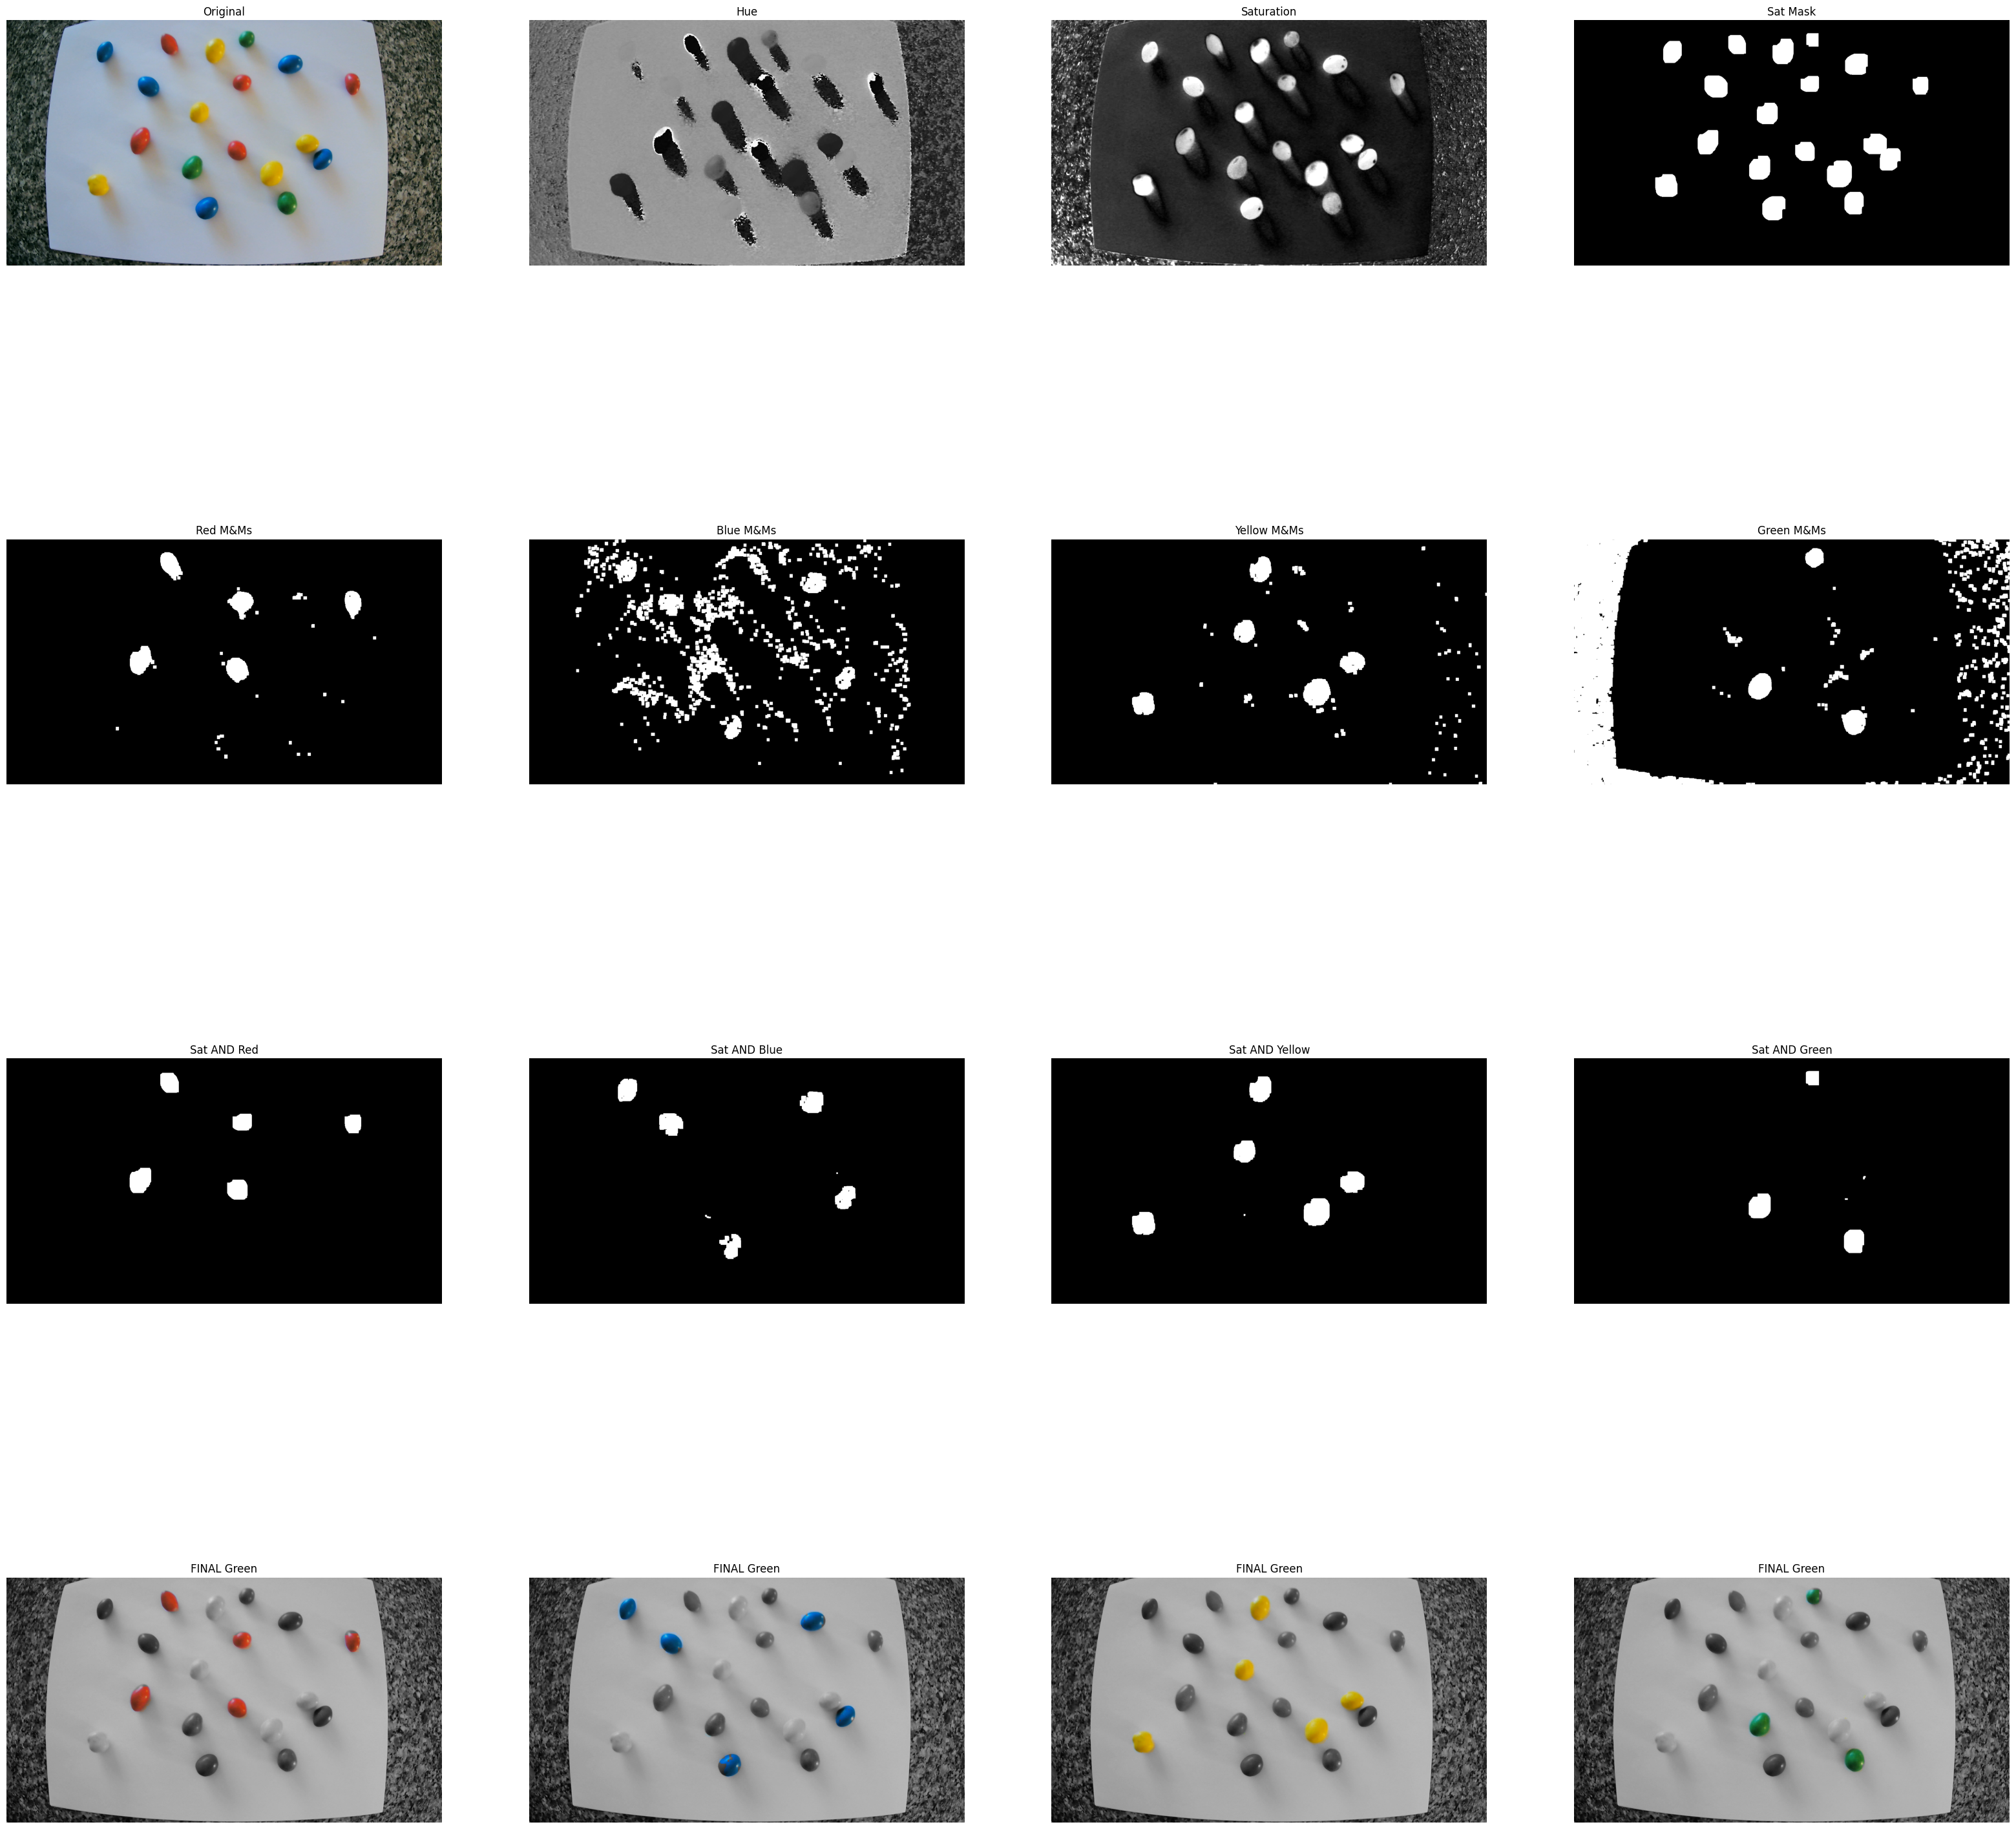

In [21]:
def composite_image(img, mask):
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    gray = cv.cvtColor(gray,cv.COLOR_GRAY2BGR)
    
    fg = cv.bitwise_and(cv.cvtColor(img,cv.COLOR_BGR2RGB), cv.cvtColor(img,cv.COLOR_BGR2RGB), mask=mask)

    background = np.full(img.shape, 255, dtype=np.uint8)
    bk = cv.bitwise_or(gray, gray, mask=cv.bitwise_not(mask))

    # combine foreground+background
    composite = cv.bitwise_or(fg, bk)


    return composite


images = sorted(glob.glob('data/WhiteBackground/calib_img_3.png'))

for fname in images:
    print(f"\n\nLoading Image {fname}")
    img = cv.imread(fname) # read image is BGR
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV_FULL) #Because full h is now 8 bit - [0,255]
    h, s, v = cv.split(hsv)

    h_blurred = cv.medianBlur(h, 3)

    mask_sat = segment_sat(s, 50)

    ks = 3 #kernel Size
    e = 3 #erodes
    d = 6 #dilates
    n = 1 # number of cycles


    mask_red = cleanup(segment_color(h, 255, 15), ks, e ,d ,n)
    mask_blue = cleanup(segment_color(h, 146, 3), ks, e ,d ,n)
    mask_yellow = cleanup(segment_color(h, 35, 5), ks, e ,d ,n)
    mask_green = cleanup(segment_color(h, 100, 30), ks, e ,d ,n) # CHECK

    mask_sat_red = cleanup(cv.bitwise_and(mask_sat,mask_red), ks, 1,3, n)
    mask_sat_blue = cleanup(cv.bitwise_and(mask_sat,mask_blue), ks, 1,3, n)
    mask_sat_yellow = cleanup(cv.bitwise_and(mask_sat,mask_yellow), ks, 1,3, n)
    mask_sat_green = cleanup(cv.bitwise_and(mask_sat,mask_green), ks, 1,3, n)
    


    final_red = composite_image(img, mask_sat_red)
    final_blue = composite_image(img, mask_sat_blue)
    final_yellow = composite_image(img, mask_sat_yellow)
    final_green = composite_image(img, mask_sat_green)

    
    
    
    
    
    plot_results()
    



    
    

# Size Calibration

[link](http://devres.zoomquiet.top/data/20160323135418/index.html)

<function matplotlib.pyplot.show(close=None, block=None)>

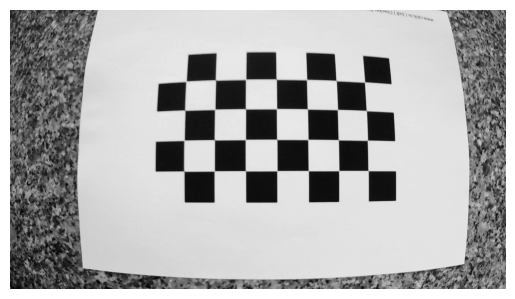

In [ ]:
img = cv.imread("data/WhiteBackground/extrinsic.png")
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.axis('off')
plt.imshow(img, cmap='gray')
plt.show

#Trying to not blur the image cause its already blurred

